In [57]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from art.utils import load_mnist, preprocess

import os
import copy

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

from tqdm import tqdm

import numdifftools as nd

In [58]:
TRAIN=False
COMPUTE_HESSIAN=True
RETRAIN=False
save_path = 'models/model5.pt'
load_path = 'models/model5.pt'

#### FL Fusion Class Selection

In [59]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties),
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [60]:
num_parties = 5
scale = 1

num_samples_erased_party = int(60000 / num_parties * scale)
num_samples_per_party = int((60000 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 12000
Number of samples other party: 12000


### 2. Load data
<a id='section_2'></a>

In [61]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

Create Trainloader

In this Notebook we are going to create it by the following principle:
 - Each client will have 50% of it's dataset given by classes common among all the clients
 - Remaining 50% will be given to each client and will be different among different clients

Example:
client 3 will have 50% given by the labels: [0,1,2,3,4]. 50% will be with data coming just from the label [7]

In [62]:
all_indices = np.arange(len(y_train))
common_classes_indices = all_indices[np.sum(y_train*np.array([1,1,1,1,1,0,0,0,0,0]), axis = 1).astype(bool)]
list_clients_dataset_indices = np.split(common_classes_indices[:-(len(common_classes_indices)%5)], 5)

for i in range(5,10):
  label = [0,0,0,0,0,0,0,0,0,0]
  label[i] = 1
  indx = all_indices[np.sum(y_train*np.array(label), axis = 1).astype(bool)]
  list_clients_dataset_indices[i-5] = np.concatenate((list_clients_dataset_indices[i-5], indx[:len(indx)//5]))

x_train_ch = np.expand_dims(x_train, axis=1)
y_train_c = np.argmax(y_train, axis=1).astype(int)
trainloader_lst = []
for indices in list_clients_dataset_indices:
  ds = TensorDataset(torch.Tensor(x_train_ch[indices]), torch.Tensor(y_train_c[indices]).long())
  trainloader_lst.append(DataLoader(ds, batch_size=128, shuffle=True))

x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=1000, shuffle=False)

In [63]:
trainloader_class_list = []
for i in range(10):
    label = [0,0,0,0,0,0,0,0,0,0]
    label[i] = 1
    indices = all_indices[np.sum(y_train*np.array(label), axis = 1).astype(bool)]
    ds = TensorDataset(torch.Tensor(x_train_ch[indices]), torch.Tensor(y_train_c[indices]).long())
    trainloader_class_list.append(DataLoader(ds, batch_size=128, shuffle=True))

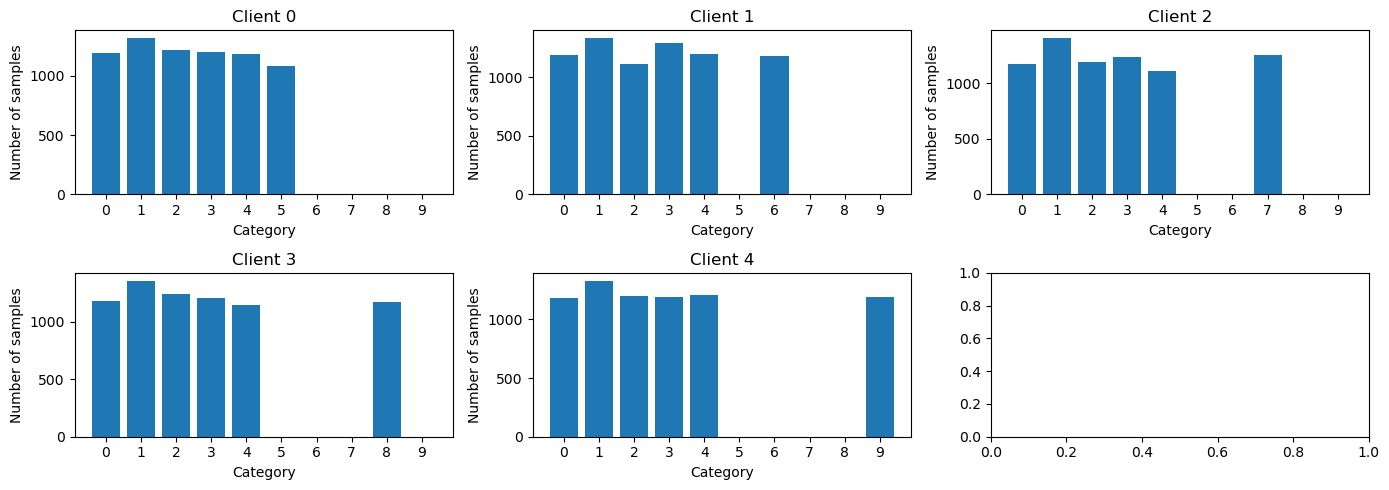

In [64]:
client_stats=[[]for i in range(5)]
for client in range(5):
    for category in range(10):
        client_indices=list_clients_dataset_indices[client]
        count=0
        for i in client_indices:
            if y_train_c[i]==category:
                count+=1
        client_stats[client].append(count)

axs = fig, axs = plt.subplots(2, 3, figsize=(14, 5))
for i,client in enumerate(client_stats):
    axs[i//3][i%3].bar(range(10),client)
    axs[i//3][i%3].set_title('Client '+str(i))
    axs[i//3][i%3].set_xticks(range(10))
    axs[i//3][i%3].set_xticklabels(range(10))
    axs[i//3][i%3].set_xlabel('Category')
    axs[i//3][i%3].set_ylabel('Number of samples')

plt.tight_layout()
plt.show()


## 2. Train the FL Model
<a id='section_3'></a>

In [65]:
num_of_repeats = 1
num_fl_rounds = 50

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

Train and evaluate the FL Model

In [66]:
class FLNet2(nn.Sequential):
    def __init__(self):
        super(FLNet2, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

In [67]:
if TRAIN:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        torch.cuda.empty_cache()
    party_models_dict = {}
    initial_model = FLNet2()
    model_dict = {}

    for fusion_key in fusion_types:
        model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

    for round_num in range(num_fl_rounds):
        local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

        for fusion_key in fusion_types:
            fusion = FL_round_fusion_selection(num_parties=num_parties, fusion_key=fusion_key)

            current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
            model = copy.deepcopy(initial_model)
            model.load_state_dict(current_model_state_dict)

            ##################### Local Training Round #############################
            party_models = []
            party_losses = []
            party_grad   = []        
            for party_id in range(num_parties):

                if fusion_key == 'Retrain':
                    break
                else:
                    model = copy.deepcopy(model).to(device)
                    model_update, party_loss = local_training.train(model=model,
                                                trainloader=trainloader_lst[party_id],
                                                device = device,
                                                criterion=None, opt=None)

                    party_models.append(copy.deepcopy(model_update.to('cpu')))
                    party_losses.append(party_loss)

                grad_norm = 0.0
                for param in model_update.parameters():
                    if param.grad is not None:
                        grad_norm += torch.norm(param.grad).cpu().item()
            
                party_grad.append(grad_norm)   
            
            grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

            loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
            ######################################################################

            current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

            model_dict[fusion_key] = copy.deepcopy(current_model_state_dict)
            party_models_dict[fusion_key] = party_models

            eval_model = FLNet2()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = Utils.evaluate(testloader, eval_model)
            clean_accuracy[fusion_key][round_num] = clean_acc
            print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

In [68]:
if TRAIN:
    def save_model_with_unique_name(model, base_path):
        # Split the base_path into the file name and extension
        base, ext = os.path.splitext(base_path)
        new_path = base_path
        counter = 1
        
        # Check if the file exists and update the filename if needed
        while os.path.exists(new_path):
            new_path = f"{base}({counter}){ext}"
            counter += 1

        torch.save(model.state_dict(), new_path)
        print(f"Model saved to {new_path}")

    eval_model = FLNet2()
    eval_model.load_state_dict(current_model_state_dict)
    save_model_with_unique_name(eval_model, save_path)

In [69]:
saved_model = FLNet2()
saved_model.load_state_dict(torch.load(load_path, weights_only=True))

<All keys matched successfully>

In [95]:
from backpack import backpack, extend
from backpack.extensions import DiagHessian

def compute_diag_hessian(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h') and param.requires_grad:
            diag_hessian_params[name] = param.diag_h.clone().detach()
            # Cleanup to avoid leftover references
            del param.diag_h

    return diag_hessian_params

def compute_information(model, criterion, dataloader_list):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = copy.deepcopy(model).to(device)
    criterion = copy.deepcopy(criterion).to(device)
    model = extend(model)
    criterion = extend(criterion)

    num_clients = len(dataloader_list)
    clients_hessians = []

    num_batches = sum(len(loader) for loader in dataloader_list)
    tqdm_bar = tqdm(total=num_batches, desc="Computing clients information", unit="batch")    

    for loader_idx, loader in enumerate(dataloader_list):
        client_hessian = {}
        for batch_idx, (inputs, targets) in enumerate(loader):
            # Compute the diag Hessian for this batch
            diag_h = compute_diag_hessian(model, criterion, inputs, targets, device=device)

            # Accumulate avarage over batches
            for name, value in diag_h.items():
                if name not in client_hessian:
                    client_hessian[name] = value/(len(loader)*num_clients)
                else:
                    client_hessian[name] += value/(len(loader)*num_clients)
                    
            tqdm_bar.update(1)

        clients_hessians.append(client_hessian)
    
    tqdm_bar.close()

    total_hessian = {}
    for name in clients_hessians[0].keys():
        total_hessian[name] = sum(client_hessian[name] for client_hessian in clients_hessians)

    
    clients_informations = []
    for client_idx in range(num_clients):
        client_info = []
        for name in clients_hessians[client_idx].keys():
            layer_info = 0.5 * torch.pow(clients_hessians[client_idx][name]/total_hessian[name], 2)
            layer_info[total_hessian[name] == 0] = 0
            client_info.append(layer_info.detach().cpu())
        clients_informations.append(client_info)
    
    return clients_informations

Compute Hessians

In [96]:
if COMPUTE_HESSIAN:
    criterion = nn.CrossEntropyLoss()
    informations = compute_information(saved_model, criterion, trainloader_lst)
    
    import pickle

    with open('cached/informations.pkl', 'wb') as f:
        pickle.dump(informations, f)

Computing clients information: 100%|██████████| 288/288 [00:25<00:00, 11.18batch/s]


Load hessians

In [107]:
import pickle
with open('cached/informations.pkl', 'rb') as f:
    informations = pickle.load(f)

party_to_be_erased = 2
info_true = informations[party_to_be_erased]

In [108]:
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, alpha=0.7, bins=50)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [0, 98])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, alpha=0.7, bins=30, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

1529377
Number of outliers: 30588


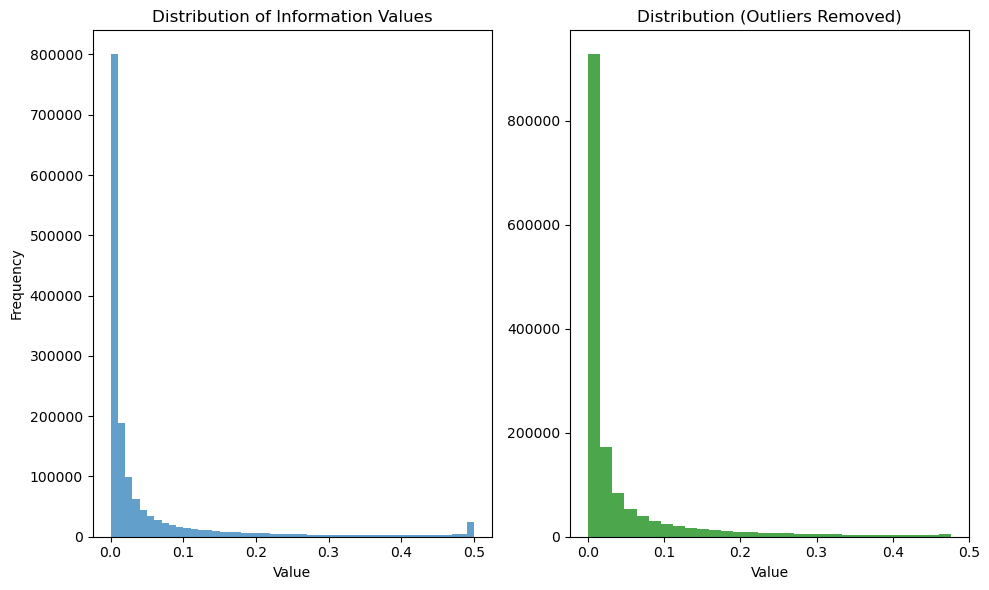

Sum of all information values: 77130.906250
Mean: 0.05043289437890053
Min: 4.858954399745334e-36
Max: 0.5
Total number of values: 1529377
Sum of all information values: 61972.816406
Mean: 0.041348591446876526
Min: 4.858954399745334e-36
Max: 0.4769485592842102
Total number of values: 1498789


(77130.90625, 61972.81640625)

In [109]:
plot_information(info_true)

Helper Functions

In [110]:
import torchmetrics
import seaborn as sns

# create validation routine
def validate(net, dl, n_classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # create metric objects
    tm_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average= 'macro', top_k=1)
    tm_con = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=n_classes)
    # move metric to device
    net.to(device)
    tm_acc.to(device)
    tm_con.to(device)
    # set network in eval mode
    net.eval()
    # at the end of epoch, validate model
    for loader_idx, loader in enumerate(dl):
        for inputs, targets in loader:
        
            inputs = inputs.to(device)
            targets = targets.to(device)
            # remove singleton dimension
            targets = targets.squeeze()
            # get output
            with torch.no_grad():
                # perform prediction
                logits = net(inputs)
            # update metrics
            _, predicted = torch.max(logits.data, 1)
            tm_acc.update(predicted, targets)
            tm_con.update(predicted, targets)

    # at the end, compute metric
    acc = tm_acc.compute()
    con = tm_con.compute()
    # set network in training mode
    
    return acc, con


def plot_confusion_matrix(conf_mat):
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(conf_mat.cpu())
    x=x.style.background_gradient(cmap=cm)
    display(x)


# Compute accuracy for each client
def compute_accuracy(model, testloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

def compute_accuracy_per_client(model, testloader_list):
    for i, testloader in enumerate(testloader_list):
        acc = compute_accuracy(model, testloader)
        print(f"Accuracy for class {i}: {acc:.2f}%")


Compute information

In [111]:
info_true=[p.cpu() for p in info_true]
infocat = torch.cat([p.flatten() for p in info_true])
s_infocat = np.sort(torch.nan_to_num(infocat))[::-1]

s_infolayers = [np.sort(p.cpu().flatten())[::-1] for p in info_true]

# plt.plot(s_infocat)
# plt.title('Sorted Information Values for All Parameters')
# plt.show()

auto_percentage = 12
custom_percentages = [None, None, None, None, None, None, None, None]

percentages = [auto_percentage if custom_percentages[i] is None else custom_percentages[i] for i in range(len(custom_percentages))]

auto_thresholds = [len(s_infolayers[i]) // 100 * percentages[i] for i in range(len(s_infolayers))]

custom_thresholds = [None, None, None, None, None, None, None, None]

thresholds = [auto_thresholds[i] if custom_thresholds[i] is None else custom_thresholds[i] for i in range(len(custom_thresholds))]

# for i in range(len(s_infolayers)):
#     fig, axs = plt.subplots(1, 1, figsize=(14, 5))
#     axs.plot(s_infolayers[i])
#     axs.axvline(auto_thresholds[i], color='red', linestyle='--', label='Auto threshold')
#     axs.axvline(thresholds[i], color='green', linestyle='--', label='Custom threshold')
#     axs.legend()
#     axs.set_title(f'Thresholds for layer {i}')
#     fig.show()

    


Parameters reset unlearning

In [112]:
thresholds_values = [p[thresholds[i]] for i,p in enumerate(s_infolayers)]
retrain_param_indices = []
for i, p in enumerate(info_true):
    if custom_thresholds[i] != 0:
        indices = torch.argwhere(p > thresholds_values[i])
        retrain_param_indices.append(indices)
    else:
        retrain_param_indices.append(torch.empty(size=[0 for _ in range(p.dim())]))

model_reset = copy.deepcopy(saved_model).cpu()
model_null = FLNet2()

original_parameters = model_reset.state_dict()
null_parameters = model_null.state_dict()

reset_parameters = {}
for i, (name, p) in enumerate(model_reset.named_parameters()):
    new_p = original_parameters[name].clone()
    null_p = null_parameters[name].clone()
    #new_p[tuple(retrain_param_indices[i].t())] = null_p[tuple(retrain_param_indices[i].t())]
    new_p[tuple(retrain_param_indices[i].t())] = 0
    reset_parameters[name] = new_p

model_reset.load_state_dict(reset_parameters)

print("Accuracy before resetting:")
compute_accuracy_per_client(saved_model, trainloader_class_list)
print("Accuracy after resetting:")
compute_accuracy_per_client(model_reset, trainloader_class_list)



Accuracy before resetting:
Accuracy for class 0: 100.00%
Accuracy for class 1: 100.00%
Accuracy for class 2: 99.97%
Accuracy for class 3: 99.95%
Accuracy for class 4: 99.98%
Accuracy for class 5: 97.45%
Accuracy for class 6: 98.68%
Accuracy for class 7: 96.81%
Accuracy for class 8: 93.95%
Accuracy for class 9: 90.65%
Accuracy after resetting:
Accuracy for class 0: 98.94%
Accuracy for class 1: 98.15%
Accuracy for class 2: 98.54%
Accuracy for class 3: 99.97%
Accuracy for class 4: 98.00%
Accuracy for class 5: 95.39%
Accuracy for class 6: 97.36%
Accuracy for class 7: 0.00%
Accuracy for class 8: 86.67%
Accuracy for class 9: 80.40%


In [113]:
print("Confusion matrix before resetting:")
acc, conf_mat = validate(saved_model, trainloader_class_list, 10)
plot_confusion_matrix(conf_mat)
print("Confusion matrix after resetting:")
acc, conf_mat = validate(model_reset, trainloader_class_list, 10)
plot_confusion_matrix(conf_mat)

Confusion matrix before resetting:


,0,1,2,3,4,5,6,7,8,9
0,5923,0,0,0,0,0,0,0,0,0
1,0,6742,0,0,0,0,0,0,0,0
2,0,2,5956,0,0,0,0,0,0,0
3,0,0,1,6128,0,0,0,1,0,1
4,0,0,0,0,5841,0,0,1,0,0
5,3,4,2,61,4,5283,37,0,23,4
6,32,12,3,1,9,4,5840,0,17,0
7,5,36,72,24,31,0,0,6065,11,21
8,19,52,59,67,25,38,21,2,5497,71
9,24,11,5,90,310,38,2,64,12,5393


Confusion matrix after resetting:


,0,1,2,3,4,5,6,7,8,9
0,5860,0,24,22,0,5,8,0,3,1
1,1,6617,18,74,3,1,7,0,20,1
2,0,3,5871,84,0,0,0,0,0,0
3,0,0,1,6129,0,1,0,0,0,0
4,0,1,77,6,5725,2,9,0,8,14
5,3,1,9,211,0,5171,12,0,14,0
6,15,3,33,13,6,46,5762,0,40,0
7,22,45,192,5101,24,117,0,0,46,718
8,5,5,125,486,3,139,6,0,5071,11
9,16,3,49,784,58,204,1,0,51,4783


In [114]:
def print_info_stats(information):
    """
    Compute statistics for the information values.
    """
    # Flatten the information values and convert to numpy
    layers_total_information = [torch.sum(p) for p in information]

    for i, info in enumerate(layers_total_information):
        print(f"Layer {i} - Total Information: {info:.4f}")
    
    print(f"Total Information: {sum(layers_total_information):.4f}")

print("Information before resetting:")
print_info_stats(info_true)

reset_info_true = copy.deepcopy(info_true)
for i in range(len(reset_info_true)):
    reset_info_true[i][tuple(retrain_param_indices[i].t())] = 0
print("Information after resetting:")
print_info_stats(reset_info_true)

Information before resetting:
Layer 0 - Total Information: 7.7394
Layer 1 - Total Information: 0.3930
Layer 2 - Total Information: 702.2592
Layer 3 - Total Information: 0.9573
Layer 4 - Total Information: 76141.1719
Layer 5 - Total Information: 14.9611
Layer 6 - Total Information: 263.1115
Layer 7 - Total Information: 0.3132
Total Information: 77130.9062
Information after resetting:
Layer 0 - Total Information: 5.8438
Layer 1 - Total Information: 0.3930
Layer 2 - Total Information: 499.7098
Layer 3 - Total Information: 0.9573
Layer 4 - Total Information: 21670.1328
Layer 5 - Total Information: 5.7317
Layer 6 - Total Information: 78.2701
Layer 7 - Total Information: 0.3132
Total Information: 22261.3516


In [115]:
class UnlearnNet(nn.Module):
    """
    A module that wraps an existing model and selectively retrains individual 
    scalar elements (indices) of its parameters while keeping the rest fixed.
    """

    def __init__(self, base_model, indices_to_retrain):
        """
        Args:
            base_model (nn.Module): The original model whose parameters 
                                    we want to partially retrain.
            indices_to_retrain (List[torch.Tensor]): For each parameter of 
                                    'base_model', a tensor of indices indicating 
                                    which scalar values should be retrained.
        """
        super().__init__()

        # We store the base model inside a dictionary to allow
        # functional calls later without overshadowing state_dict keys.
        self.inner_model = {"model": base_model}

        # Move any index tensors to CPU and store them.
        self.indices_to_retrain = [idx.cpu() for idx in indices_to_retrain]

        # Create a copy of the base model's parameters as buffers, where
        # we zero out the positions that will be retrained.
        base_params = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            # Detach a clone of the original parameter
            cloned_param = param.clone().detach()
            # Zero-out the entries we plan to retrain
            if len(self.indices_to_retrain[i]) > 0:
                cloned_param[tuple(self.indices_to_retrain[i].t())] = 0
            base_params[param_name] = cloned_param

        # Register these base parameters as buffers so they are not optimized
        for param_name, buf in base_params.items():
            buf_name = param_name.replace(".", "_")
            self.register_buffer(f"base_{buf_name}", buf)

        # Create the new learnable parameters for only the chosen indices
        retrain_params_dict = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # We create a 1D tensor (one entry per retrained element)
            key = param_name.replace(".", "_")
            retrain_params_dict[key] = nn.Parameter(
                torch.zeros(len(self.indices_to_retrain[i]))
            )
        self.retrain_params = nn.ParameterDict(retrain_params_dict)

        # Build sparse masks to apply the learnable values at the correct indices
        sparse_masks = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # 'retrain_indices' has shape (k, n_dims). Add a final dim to index positions in the retrain-param vector.
            retrain_indices = indices_to_retrain[i]
            k = retrain_indices.size(0)

            # Create an index column [0..k-1], then concatenate it with 'retrain_indices'.
            row_idx = torch.arange(k).unsqueeze(1)
            final_idx_matrix = torch.cat([retrain_indices, row_idx], dim=1)

            # A sparse_coo_tensor expects indices with shape (ndim, nnz). Transpose to (n_dims+1, k).
            indices_for_sparse = final_idx_matrix.t().contiguous()

            # Append k as the final dimension so each retrained element indexes differently.
            mask_shape = tuple(param.size()) + (k,)

            # Build the sparse mask with 1.0 at the retrained indices.
            key = f"mask_{param_name.replace('.', '_')}"
            sparse_masks[key] = torch.sparse_coo_tensor(
                indices_for_sparse,
                torch.ones(k, dtype=torch.float32),
                size=mask_shape
            )
        
        # Register these sparse masks as buffers
        for mask_name, mask in sparse_masks.items():
            self.register_buffer(mask_name, mask.coalesce())

    def contract_last_dim_with_vector(self, sp_tensor: torch.Tensor, vec: torch.Tensor) -> torch.Tensor:
        """
        Contract the last dimension of a sparse tensor (shape [..., N]) with
        a dense vector of shape (N,), returning a sparse tensor of shape [...].

        This effectively applies elementwise multiplication with 'vec'
        across the last dimension of 'sp_tensor'.
        """

        # Extract indices (shape [ndim, nnz]) and values (shape [nnz])
        indices = sp_tensor.indices()
        values = sp_tensor.values()

        # Multiply each sparse value by the corresponding element in 'vec'
        # indices[-1] indicates which element in 'vec' to use per sparse entry
        new_values = values * vec[indices[-1]]

        # Create a new sparse_coo_tensor with one fewer dimension
        new_shape = sp_tensor.shape[:-1]
        new_indices = indices[:-1, :]  # drop the last dimension index row

        result_tensor = torch.sparse_coo_tensor(
            new_indices,
            new_values,
            size=new_shape,
            dtype=sp_tensor.dtype,
            device=sp_tensor.device
        )

        return result_tensor

    def forward(self, x):
        """
        Forward pass using a functional call to the base model. We reconstruct 
        final parameters by adding the base buffers and the contracted retrain 
        parameters at the relevant indices.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )

        # Perform a functional forward pass with the reconstructed parameters
        return torch.func.functional_call(model, final_params, x)
    
    def get_retrained_params(self):
        """
        Returns the retrained parameters of the model.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )
        
        detached_params = {}
        for key, value in final_params.items():
            detached_params[key] = value.cpu().detach()
        return detached_params
    

In [116]:
assert RETRAIN
#Test
unlearn_model = UnlearnNet(model_reset, retrain_param_indices)

print("Unlearn model parameters:")
for name , param in unlearn_model.named_parameters():
    print(name, param.shape)

# print("Accuracy (reset before retrain)")
# compute_accuracy_per_client(unlearn_model, trainloader_class_list)


AssertionError: 

In [ ]:
num_of_repeats = 1
num_fl_rounds = 1

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 2

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()

party_models_dict = {}
initial_model = unlearn_model
model_dict = {}
parties = list(range(5))
del parties[party_to_be_erased]

for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds):
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=len(parties), fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        model = copy.deepcopy(initial_model)
        model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        party_grad   = []        
        for party_id in parties:

            if fusion_key == 'Retrain':
                break
            else:
                print(f"Training party {party_id}")
                model = UnlearnNet(model_reset, retrain_param_indices)
                model.load_state_dict(current_model_state_dict)
                model.to(device)
                model_update, party_loss = local_training.train(model=model,
                                            trainloader=trainloader_lst[party_id],
                                            device = device,
                                            criterion=None, opt=None)
                model_update_copy = UnlearnNet(model_reset, retrain_param_indices)
                model_update_copy.load_state_dict(model_update.state_dict())
                model_update_copy.to("cpu")
                party_models.append(model_update_copy)
                party_losses.append(party_loss)

            grad_norm = 0.0
            for name,param in model_update.named_parameters():
                if param.grad is not None:
                    grad_norm += torch.norm(param.grad).cpu().item()
                    #print(f"Gradient norm for {name}: {grad_norm}")
                else:
                    #print(f"Gradient is None for {name}")
                    pass
        
            party_grad.append(grad_norm)   
        
        grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

        eval_model = copy.deepcopy(initial_model).to("cpu")
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(testloader, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

Training party 0
Training party 1
Training party 2
Training party 3
Global Clean Accuracy FedAvg, round 0 = 88.58


In [ ]:
print("Accuracy after retrain")
compute_accuracy_per_client(eval_model, trainloader_class_list)


Accuracy after retrain
Accuracy for class 0: 100.00%
Accuracy for class 1: 99.97%
Accuracy for class 2: 99.88%
Accuracy for class 3: 99.90%
Accuracy for class 4: 99.95%
Accuracy for class 5: 97.55%
Accuracy for class 6: 98.90%
Accuracy for class 7: 98.96%
Accuracy for class 8: 95.52%
Accuracy for class 9: 0.27%


In [ ]:
print("Confusion matrix after retrain:")
acc, conf_mat = validate(eval_model, trainloader_class_list, 10)
plot_confusion_matrix(conf_mat)

Confusion matrix after retrain:


,0,1,2,3,4,5,6,7,8,9
0,5923,0,0,0,0,0,0,0,0,0
1,0,6740,1,0,1,0,0,0,0,0
2,0,2,5951,2,0,0,0,3,0,0
3,0,0,1,6125,0,2,0,2,1,0
4,0,0,0,0,5839,0,1,2,0,0
5,3,0,1,98,1,5288,15,2,13,0
6,19,8,3,2,8,21,5853,0,4,0
7,5,25,13,8,8,1,0,6200,5,0
8,15,14,38,58,30,57,36,14,5589,0
9,70,16,16,131,3060,295,0,2063,282,16
